In [7]:
import pylab as plt
import tqdm as tqdm
import pandas as pd
from herbie import FastHerbie
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import warnings
import pyproj
import matplotlib.patches as patches
warnings.filterwarnings('ignore')
import pickle

# Functions defining wind rotations

In [2]:

def uv_to_earth(lon, lat, proj, u, v):
    
    m = proj.get_factors(lon, lat)
    
    dy_dphi = m.dy_dphi
    dy_dlam = m.dy_dlam

    alpha = -np.arctan2(-np.cos(np.deg2rad(lat)) * np.deg2rad((1.0/dy_dlam)),np.deg2rad((1.0/dy_dphi)))
    
    return u * np.cos(alpha) - v * np.sin(alpha), v * np.cos(alpha) + u * np.sin(alpha)


def uv_to_grid2(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)
    
    dy_dphi = m.dy_dphi
    dy_dlam = m.dy_dlam

    alpha = np.arctan2(-np.cos(np.deg2rad(lat)) * np.deg2rad((1.0/dy_dlam)),np.deg2rad((1.0/dy_dphi)))
    
    return u * np.cos(alpha) - v * np.sin(alpha), v * np.cos(alpha) + u * np.sin(alpha)

# Set date ranges for simulation 

In [3]:
#DATES = pd.date_range('2021-03-13 15:00', '2021-03-13 20:00', freq='1H')
DATES = pd.date_range('2021-03-08 00:00', '2021-03-16 00:00', freq='1H')
#DATES = pd.date_range('2021-03-10 15:00', '2021-03-10 20:00', freq='1H')

of_name = DATES[0].strftime("%y-%m-%d-%Hz") + '_to_' + DATES[-1].strftime("%y-%m-%d-%Hz")

width = 100             # Halfwidth of data subset 

# Domains center
# lat_center = 35.2
# lon_center = -122.70

lat_center = 35.00
lon_center = -123.71
proj_lon_center = -68.0

# This just for plotting
buoy_lat = 35.71074
buoy_lon = -121.84606 

domain_Lx = 420 * 1000.
domain_Ly = 420 * 1000.
domain_nx = 420
domain_ny = 420
domain_nhalo = 5 
domain_dx = domain_Lx/domain_nx
domain_dy = domain_Ly/domain_ny

print(domain_dx)

x = np.linspace(-domain_Lx/2 - domain_nhalo * domain_dx, +domain_Lx/2 + domain_nhalo * domain_dx, domain_nx + 2 * domain_nhalo, endpoint=False)
y = np.linspace(-domain_Ly/2 - domain_nhalo * domain_dy, +domain_Ly/2 + domain_nhalo * domain_dy, domain_ny + 2 * domain_nhalo, endpoint=False)


domain_x, domain_y = np.meshgrid(x,y)


out_file_header = '/home/xiao169/scratch/pinacles_in_' + of_name

1000.0


# Set-up map projection for HRRR

In [4]:
projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5],
                             globe=ccrs.Globe(ellipse="sphere", semimajor_axis=6370000,  semiminor_axis=6370000))


proj = pyproj.Proj(projection)

# Set-up map projection for PINACLES

In [5]:
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)

projection_pinacles = ccrs.LambertConformal(central_longitude=proj_lon_center, central_latitude=lat_center,
                            standard_parallels=(lat_center, lat_center), globe=globe)


pinacles_proj = pyproj.Proj(projection_pinacles)
pc = ccrs.PlateCarree()

## Open ZARR file and rename variables consistent with what PINACLES Expects

In [ ]:
sfc_zarr_file = '/home/xiao169/scratch/' + of_name + '_surface.zarr'
levels_zarr_file = '/home/xiao169/scratch/' + of_name + '_levels.zarr'

#First for surface variables
ds = xr.open_zarr(sfc_zarr_file) 
# Rename vairables consistent with what 
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
ds = ds.rename_vars({"t":"SST"})
ds = ds.rename_vars({"t2m":"T2m"})
ds = ds.rename_vars({"sh2":"QV2m"})

ds = ds.rename_vars({"u10":"U10m"})
ds = ds.rename_vars({"v10":"V10m"})

ds = ds.rename_vars({"sp":"PSFC"})

#Next for native grid
ds_p = xr.open_zarr(levels_zarr_file)
ds_p = ds_p.assign_coords(longitude=(((ds_p.longitude + 180) % 360) - 180))
ds_p = ds_p.rename_vars({"pres":"P"})
ds_p = ds_p.rename_vars({"t":"T"})
ds_p = ds_p.rename_vars({"gh":"Z"})
ds_p = ds_p.rename_vars({"q":"QV"})
ds_p = ds_p.rename_vars({"clwmr":"QC"})
ds_p = ds_p.rename_vars({"unknown":"QI"})
ds_p = ds_p.rename_vars({"u":"U"})
ds_p = ds_p.rename_vars({"v":"V"})


In [ ]:
nt = ds.time.shape[0]
print(nt)

In [ ]:
u_ti = ds_p.U.isel(time=slice(0, 1), x=xslice, y=yslice)
u_ti.to_netcdf('/home/xiao169/scratch/1.nc', unlimited_dims="time")
u_ti = ds_p.U.isel(time=slice(1, 2), x=xslice, y=yslice)
u_ti.to_netcdf('/home/xiao169/scratch/2.nc', unlimited_dims="time")

# Define a function for finding the closest gridpoint to the data subset center and then use it do determine the slices of HRRR data to extract.

In [ ]:
def get_nearest_point(projection, longitude, latitude):
    xa = np.arange(-2.698e+06, 2.696e+06+3000.0, 3000.0)
    ya = np.arange(-1.587e+06, 1.587e+06, 3000.0)
    
    #x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())

    proj_2 = pyproj.Transformer.from_crs(pc, projection)
    
    x, y = proj_2.transform(longitude, latitude)
    
    xi = np.argmin(np.abs(x - xa))
    yi = np.argmin(np.abs(y - ya))
    
    return xi , yi


xi_buoy, yi_buoy = get_nearest_point(projection, buoy_lon,  buoy_lat)
xi, yi = get_nearest_point(projection, lon_center,  lat_center )
xslice = slice(xi - width, xi + width)
yslice = slice(yi - width,  yi + width)
print(ds.longitude.values[yi, xi], ds.latitude.values[yi, xi])

print('Slices of HRRR domain to extract')
print(xslice, yslice)

# Plot domain and potentially nests

In [10]:
with open('../morro_bay_wea/wea_boundary.pkl', 'rb') as f:
    wea_bdy = pickle.load(f)

In [17]:
wea_bdy[:,0]

array([-122.05742197, -122.04414786, -122.03087383, -122.01759987,
       -122.01773288, -122.00446078, -121.99118876, -121.99132529,
       -121.97805099, -121.96478097, -121.95151102, -121.95165286,
       -121.93838478, -121.92511678, -121.92526213, -121.911996  ,
       -121.89872995, -121.88546397, -121.88561463, -121.87235053,
       -121.85908651, -121.85924067, -121.84597853, -121.83271646,
       -121.83287413, -121.81961394, -121.80635384, -121.806515  ,
       -121.79325677, -121.77999863, -121.76674058, -121.76690702,
       -121.75365084, -121.74039478, -121.74056471, -121.72731054,
       -121.71405646, -121.71422987, -121.70097767, -121.70115277,
       -121.70132778, -121.70150269, -121.70167751, -121.70185224,
       -121.68860905, -121.68878546, -121.67554415, -121.67572225,
       -121.6624828 , -121.66266259, -121.64942502, -121.64960648,
       -121.63637078, -121.62313519, -121.60989969, -121.59666429,
       -121.59685276, -121.59704113, -121.58380938, -121.58399

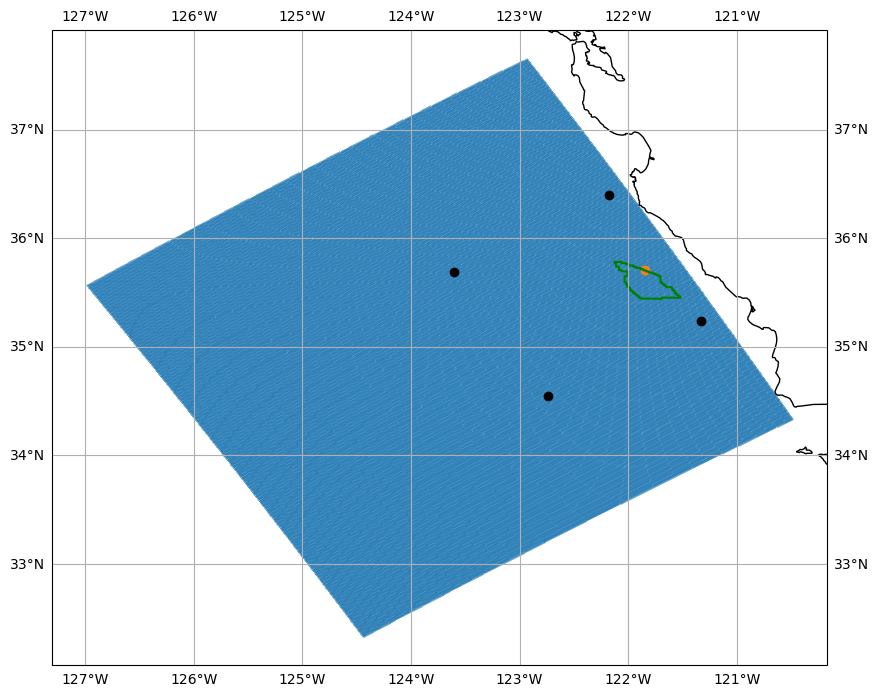

In [18]:


x_center, y_center = projection_pinacles.transform_point(lon_center, lat_center, pc)

x_d = domain_x + x_center
y_d = domain_y + y_center 

tran_pinacles_2_pc = pyproj.Transformer.from_crs(projection_pinacles, pc)

domain_lon, domain_lat = tran_pinacles_2_pc.transform(x_d, y_d)
plt.figure(1, figsize=(10,10))
ax = plt.axes(projection=pc)
ax.scatter(domain_lon[:, :], domain_lat[:, :],s=0.1)


nnest = 150
ll_corner = (125,264)
ur_corner = (ll_corner[0] + nnest, ll_corner[1] + nnest)
lr_corner = (ll_corner[0], ll_corner[1] + nnest)
ul_corner = (ll_corner[0] + nnest, ll_corner[1])


ax.scatter(domain_lon[ll_corner], domain_lat[ll_corner], c='black')
ax.scatter(domain_lon[ur_corner], domain_lat[ur_corner], c='black')
ax.scatter(domain_lon[lr_corner], domain_lat[lr_corner], c='black')
ax.scatter(domain_lon[ul_corner], domain_lat[ul_corner], c='black')
ax.plot(wea_bdy[:,0], wea_bdy[:,1], c='green')
ax.scatter(buoy_lon, buoy_lat)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
plt.savefig('domain_2.png', dpi=400)

# Subset data from zarr in to netCDF file that will be read by PINACLES. 
We also rotate winds from HRRRs model grid onto PINACLES's model grid. We start with the surface.

In [ ]:
for ti in ds.
# First prepare the SST
sst =ds.SST.isel(x=xslice, y=yslice)
sst.to_netcdf(out_file)

#land = ds.LAND.isel(x=xslice, y=yslice)
#land.to_netcdf(out_file, 'a')

t2m = ds.T2m.isel(x=xslice, y=yslice)
t2m.to_netcdf(out_file, 'a')

qv2m = ds.QV2m.isel(x=xslice, y=yslice)
qv2m.to_netcdf(out_file, 'a')

u10m = ds.U10m.isel(x=xslice, y=yslice)
v10m = ds.V10m.isel(x=xslice, y=yslice)
lon = v10m.longitude.values
lat = u10m.latitude.values


# Rotate wind into PINACLES Projection
for ti in tqdm.tqdm(range(u10m.values.shape[0])):
    u_grid, v_grid = uv_to_earth(lon, lat, proj,u10m.values[ti,:,:],v10m.values[ti,:,:]) 
    u10m.values[ti, :,:],v10m.values[ti, :,:] =  uv_to_grid2(lon, lat, pinacles_proj,u_grid, v_grid)  #projection_pinacles.transform_vectors(projection,lon, lat,u10m.values[ti,:,:],v10m.values[ti,:,:])

u10m.to_netcdf(out_file, 'a')
v10m.to_netcdf(out_file, 'a')

pres = ds.PSFC.isel(x=xslice, y=yslice)
pres.to_netcdf(out_file, 'a')



# Subset data from zarr in to netCDF file that will be read by PINACLES. 
We also rotate winds from HRRRs model grid onto PINACLES's model grid. Now we do the level data.

In [ ]:
p = ds_p.P.isel(x=xslice, y=yslice)
p.to_netcdf(out_file, 'a')
#p = None

t = ds_p.T.isel(x=xslice, y=yslice)
t.to_netcdf(out_file, 'a')
#t = None

z =  ds_p.Z.isel(x=xslice, y=yslice)
z.to_netcdf(out_file, 'a')
#z = None

qv  =  ds_p.QV.isel(x=xslice, y=yslice)
qv.to_netcdf(out_file, 'a')
#qv = None

qc = ds_p.QC.isel(x=xslice, y=yslice)
qc.to_netcdf(out_file, 'a')
#qc = None

qi =  ds_p.QI.isel(x=xslice, y=yslice)
qi.to_netcdf(out_file, 'a')
#qi = None

u =  ds_p.U.isel(x=xslice, y=yslice)
v =  ds_p.V.isel(x=xslice, y=yslice)


lon = u.longitude.values
lat = u.latitude.values

u_pc = np.empty_like(u.values)
v_pc = np.empty_like(v.values)

# Rotate winds to PINACLES Projeciton 
for ti in tqdm.tqdm(range(u.values.shape[0])):
    for ki in range(u.values.shape[1]):
        u_pc[ti, ki,:,:],v_pc[ti, ki,:,:] = uv_to_earth(lon, lat, proj,u.values[ti, ki,:,:],v.values[ti, ki,:,:])
        u.values[ti, ki,:,:],v.values[ti, ki,:,:] = uv_to_grid2(lon, lat, pinacles_proj,u_pc[ti, ki,:,:],v_pc[ti, ki,:,:])

u.to_netcdf(out_file, 'a')  
v.to_netcdf(out_file, 'a')


In [ ]:
x_center, y_center = projection_pinacles.transform_point(lon_center, lat_center, pc)

x_d = domain_x + x_center
y_d = domain_y + y_center 

tran_pinacles_2_pc = pyproj.Transformer.from_crs(projection_pinacles, pc)

domain_lon, domain_lat = tran_pinacles_2_pc.transform(x_d, y_d)
plt.figure(1, figsize=(10,10))
ax = plt.axes(projection=pc)
ax.contourf(lon, lat, qv2m[0,:,:], levels=25)
ax.scatter(domain_lon[:, :], domain_lat[:, :],s=0.01)


nnest = 150
ll_corner = (125,264)
ur_corner = (ll_corner[0] + nnest, ll_corner[1] + nnest)
lr_corner = (ll_corner[0], ll_corner[1] + nnest)
ul_corner = (ll_corner[0] + nnest, ll_corner[1])


ax.scatter(domain_lon[ll_corner], domain_lat[ll_corner], c='black', s= 0.5)
ax.scatter(domain_lon[ur_corner], domain_lat[ur_corner], c='black', s= 0.5)
ax.scatter(domain_lon[lr_corner], domain_lat[lr_corner], c='black', s= 0.5)
ax.scatter(domain_lon[ul_corner], domain_lat[ul_corner], c='black', s= 0.5)
ax.scatter(buoy_lon, buoy_lat, s=0.5)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
plt.savefig('domain.png', dpi=800)


print(lr_corner)